# Телеком

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах

**Цель:** построить модель машинного обучения, которая предскажет отток клиентов компании с метрикой ROC-AUC больше 0.85.

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

contract.csv:

- customerID - уникальный ID клиента
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания пользования услугами
- Type - Тип оплаты за услуги (Month-to-month, One year, Two year)
- PaperlessBilling - безналичный расчет
- PaymentMethod - способы оплаты за услуги (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges - ежемесячные платежи
- TotalCharges - общая сумма платежа

personal.csv:

- customerID - уникальный ID клиента
- gender - пол клиента
- Partner - наличие супруга(и)
- Dependents - наличие иждивенцев
- SeniorCitizen - пенсионер

internet.csv:

- customerID - уникальный ID клиента
- InternetService - вид подключения интернет-соединения (DSL, Fiber optic)
- OnlineSecurity - блокировка небезопасных сайтов
- OnlineBackup - облачное хранилище файлов
- DeviceProtection - Наличие услуги антивируса
- TechSupport - выделенная линии технической поддержки
- StreamingTV - стриминговое телевидения
- StreamingMovies - каталог фильмов

phone.csv:

- customerID - уникальный ID клиента
- MultipleLines - наличие возможности ведения параллельных линий во время звонка

# План работы

Провести предобработку данных:
- проверить на пропуски, дубликаты, выбросы, привести признаки к необходимому формату и объеденить таблицу. 

Провести исследовательский анализ:
- посмотреть на распределение целевого признака
- посмотреть на другие признаки и оценить их влияние на целевой

Построить модель:
- подготовить данные к обучению модели (кодирование категориальных и масштабирование кол-ных признаков, разбивка на обучающую и тестовую выборку)
- обучить несколько моделей с подбором оптимальных для нее параметров для массимизация метрики (roc auc, accuracy) 
- выбрать лучшую модель и подвести итоги

## Исследовательский анализ данных

### Предварительный анализ

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import lightgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.options.mode.chained_assignment = None

In [2]:
# /datasets/final_provider/   customerID

df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
df_list = [df_contract, df_personal, df_internet, df_phone]
for df in df_list:
    display(df)
    df.info()
    display(df.describe())
    print("Дубликаты:", sum(df.duplicated()))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Дубликаты: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Дубликаты: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0233-FTHAV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Дубликаты: 0


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,6266-QHOJZ,No
freq,1,3390


Дубликаты: 0


- дубликатов и явных выбросов и пропусков не обнаружено, признак TotalCharges имеет тип object, что говорит о наличии в ней не только числовых значений. 
- так же стоит проанализировать признаки BeginDate, EndDate и привести их к единому по логиге типу.
- наблюдений в таблицах df_internet (5517) и df_phone (6361) меньше общего кол-ва клиентов ((customerID - 7043), нкжно это иметь ввиду при дальнейшем объединении таблиц и подумать как заполнить образовавшиеся пропуски

### Предобработка данных

In [4]:
df_contract['temp_TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'],errors='coerce')

In [5]:
df_contract[df_contract['temp_TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,temp_TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,NaN


Пропуски в TotalCharges соответсвуют дате подписания контракта в 2020-02-01, что является последним днем содержащие наши данные. Эти строки можно удалить, не потеряв в информативности. 

In [6]:
df_contract = df_contract[~df_contract['temp_TotalCharges'].isna()]
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,temp_TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,151.65
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,1990.50
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,7362.90
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,306.60


In [7]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7032 non-null   object 
 1   BeginDate          7032 non-null   object 
 2   EndDate            7032 non-null   object 
 3   Type               7032 non-null   object 
 4   PaperlessBilling   7032 non-null   object 
 5   PaymentMethod      7032 non-null   object 
 6   MonthlyCharges     7032 non-null   float64
 7   TotalCharges       7032 non-null   float64
 8   temp_TotalCharges  7032 non-null   float64
dtypes: float64(3), object(6)
memory usage: 549.4+ KB


In [8]:
sum(df_contract['EndDate']=='No')

5163

In [9]:
df_contract['PaperlessBilling'].value_counts()

Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64

In [10]:
df_contract['is_left'] = df_contract['EndDate'] != 'No'
#df_contract['PaperlessBilling'] = df_contract['PaperlessBilling'] == 'Yes'


In [11]:
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,temp_TotalCharges,is_left
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,29.85,False
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,1889.50,False
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,108.15,True
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1840.75,False
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,151.65,True
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,1990.50,False
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,7362.90,False
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,346.45,False
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,306.60,True


In [12]:
# EndDate=2020-02-01'
df_contract['EndDate'] = df_contract['EndDate'].replace('No','2020-02-01')
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,temp_TotalCharges,is_left
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,29.85,False
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1889.50,False
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,108.15,True
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1840.75,False
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,151.65,True
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,1990.50,False
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,7362.90,False
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,346.45,False
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,306.60,True


In [13]:
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

In [14]:
# df_contract['duration_months'] = (((df_contract['EndDate'].dt.year - df_contract['BeginDate'].dt.year) * 12) + 
#                      df_contract['EndDate'].dt.month - df_contract['BeginDate'].dt.month)

df_contract['duration_days'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days

In [15]:
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,temp_TotalCharges,is_left,duration_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,29.85,False,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1889.50,False,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,108.15,True,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1840.75,False,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,151.65,True,61
...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,1990.50,False,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,7362.90,False,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,346.45,False,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,306.60,True,123


In [16]:
df_contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

In [17]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Type, dtype: int64

In [18]:
df_contract.drop(columns=['BeginDate', 'EndDate', 'temp_TotalCharges'], inplace=True)
df_contract

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_left,duration_days
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,False,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,False,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,True,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,False,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,True,61
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,False,730
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,False,2191
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,False,337
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,True,123


Удалили лишние столбцы, в т.ч. даты пользования услугой, т.к. для обучения модели создали столбец с продолжительностью пользования, а сохраненеие EndDate и вовсе черевато утечкой данных для обучения

In [19]:
df_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [20]:
df_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [21]:
# заменяем кол-ные переменные, потом их вместе закодируем ohe
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].replace(1, 'Yes')
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].replace(0, 'No')

In [22]:
df_personal.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,6266-QHOJZ,Male,No,No,No
freq,1,3555,5901,3641,4933


In [23]:
# df_personal['Partner'] = df_personal['Partner'] == 'Yes'
# df_personal['Dependents'] = df_personal['Dependents'] == 'Yes'
# df_personal

In [24]:
df_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [25]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0233-FTHAV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [29]:
df_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [30]:
df_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [31]:
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,6266-QHOJZ,No
freq,1,3390


In [32]:
df_phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

In [33]:
df_contract

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_left,duration_days
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,False,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,False,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,True,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,False,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,True,61
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,False,730
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,False,2191
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,False,337
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,True,123


### Анализ данных

In [34]:
df_contract.describe()

,MonthlyCharges,TotalCharges,duration_days
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,987.538538
std,30.085974,2266.771362,747.153663
min,18.250000,18.800000,30.000000
25%,35.587500,401.450000,275.000000
50%,70.350000,1397.475000,883.000000
75%,89.862500,3794.737500,1676.000000
max,118.750000,8684.800000,2191.000000


In [35]:
df_contract['is_left'].value_counts()

False    5163
True     1869
Name: is_left, dtype: int64

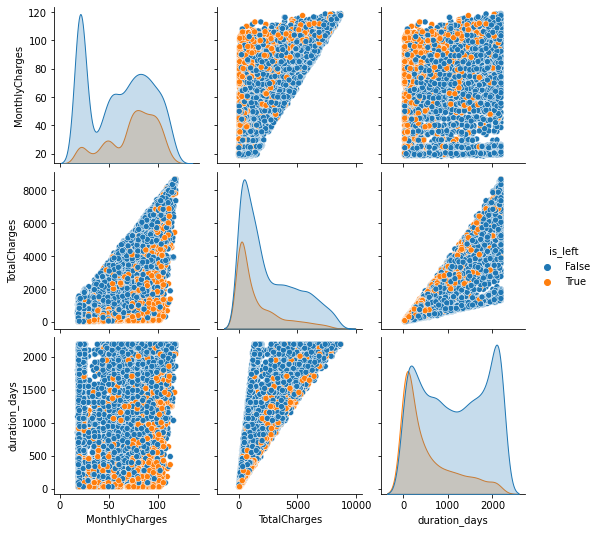

In [36]:
sns.pairplot(df_contract, hue='is_left') 

- с увеличением помесячных платежей кол-во ушедших увеличивается, можно отметить резкий рост с платежа=60
- в первые месяцы кол-во ушедших клиентов велико, почти каждый второй уходит, однако со временем их кол-во уменьшается.
- среди пользователелей пользующиеся безналичнам расчетом доля ущедших больше

In [37]:
df = (df_contract.merge(df_personal, on =['customerID'], how='inner')
                .merge(df_internet, on =['customerID'], how='left')
                .merge(df_phone, on =['customerID'], how='left'))


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   is_left           7032 non-null   bool   
 7   duration_days     7032 non-null   int64  
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   object 
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   5512 non-null   object 
 13  OnlineSecurity    5512 non-null   object 
 14  OnlineBackup      5512 non-null   object 
 15  DeviceProtection  5512 non-null   object 
 16  TechSupport       5512 non-null   object 


In [39]:
for col in df_internet.columns:
     if col != 'customerID':
        #if col != 'InternetService':
        df[col].fillna("No", inplace=True)
            #df[col] = (df[col] == 'Yes').astype(int)

In [40]:
df['MultipleLines'].fillna('No', inplace=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   is_left           7032 non-null   bool   
 7   duration_days     7032 non-null   int64  
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   object 
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   7032 non-null   object 
 13  OnlineSecurity    7032 non-null   object 
 14  OnlineBackup      7032 non-null   object 
 15  DeviceProtection  7032 non-null   object 
 16  TechSupport       7032 non-null   object 


## Создание модели прогноза

### Подготовка данных к обучению

In [42]:
df['is_left'].value_counts()

False    5163
True     1869
Name: is_left, dtype: int64

In [43]:
df_ohe = df.copy().set_index('customerID')
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_ohe.info()
df_ohe.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   TotalCharges                           7032 non-null   float64
 2   is_left                                7032 non-null   bool   
 3   duration_days                          7032 non-null   int64  
 4   Type_One year                          7032 non-null   uint8  
 5   Type_Two year                          7032 non-null   uint8  
 6   PaperlessBilling_Yes                   7032 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 8   PaymentMethod_Electronic check         7032 non-null   uint8  
 9   PaymentMethod_Mailed check             7032 non-null   uint8  
 10  gender_Male                            7032 non-null   uint8  

,MonthlyCharges,TotalCharges,is_left,duration_days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,29.85,False,31,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,1889.50,False,1036,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,108.15,True,61,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,1840.75,False,1371,1,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,151.65,True,61,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [44]:
df_ohe['is_left'] = df_ohe['is_left'].astype(int)

In [45]:
X = df_ohe.drop(columns='is_left')
y = df_ohe['is_left']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5274, 22), (1758, 22), (5274,), (1758,))

In [47]:
numeric = ['MonthlyCharges', 'TotalCharges', 'duration_days']

In [48]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [49]:
X_train.head()

,MonthlyCharges,TotalCharges,duration_days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
6849-OYAMU,1.162877,-0.179659,-0.550397,1,0,0,0,0,0,1,...,1,1,0,0,1,0,1,1,1,0
6629-CZTTH,-0.305269,-0.984606,-1.283861,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
3452-SRFEG,0.321096,0.624738,0.671596,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
5129-HHMZC,0.713817,0.560688,0.428001,0,1,0,1,0,0,0,...,0,0,0,1,1,0,1,1,1,1
2135-RXIHG,-0.638336,-0.989019,-1.283861,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### LogisticRegression, RandomForestClassifier, DecisionTreeClassifier

In [50]:
def models_train_metrics(features_train, features_valid, target_train, target_valid):
    
    models = {'Decision Tree': DecisionTreeClassifier(random_state=42), 
              'Random Forest': RandomForestClassifier(random_state=42),
              'Logistic Regression': LogisticRegression(random_state=42)}
   
    table = {}
    for model in models:
        scores = {}
        cur_model = models[model]
        cur_model.fit(features_train, target_train)
        prediction = cur_model.predict(features_valid) 
        prediction_ra = cur_model.predict_proba(features_valid)[:, 1]
        scores['accuracy'] = accuracy_score(target_valid, prediction)
        scores['roc_auc'] = roc_auc_score(target_valid, prediction_ra)
        table[model]=scores
    return pd.DataFrame(table)

In [51]:
%%time
simple_models = models_train_metrics(X_train, X_test, y_train, y_test)
simple_models

CPU times: user 1 s, sys: 816 ms, total: 1.82 s
Wall time: 1.85 s


,Decision Tree,Random Forest,Logistic Regression
accuracy,0.762230,0.808874,0.810011
roc_auc,0.694429,0.840645,0.840516


Logistic Regression и Random Fores имеют примерно равные показатели измеряемых метрик, а близки к удовлетворению поставленных целей. Если дальнейшая модель с применением бустинга не покажет лучшего результата, можно будет доработать одну из моделей путем подбора оптимальных параметров.

### LGBMClassifier

In [52]:
%%time
params = {
     'n_estimators': [200, 400],
     'max_depth': [4, 10, 20]
}

grid = GridSearchCV(LGBMClassifier(random_state=42, 
                                   objective='binary',
                                   class_weight='balanced', num_leaves=100),
                    param_grid=params, verbose=3, 
                    cv=3, n_jobs=-1, scoring='roc_auc') 
grid.fit(X_train, y_train)


print('model params: ', grid.best_params_)
print(f"LGBMClassifier roc_auc: {grid.best_score_:.3f}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..................max_depth=4, n_estimators=200; total time=  34.3s
[CV 2/3] END ..................max_depth=4, n_estimators=200; total time=  51.0s
[CV 3/3] END ..................max_depth=4, n_estimators=200; total time= 5.1min
[CV 1/3] END ..................max_depth=4, n_estimators=400; total time= 2.8min
[CV 2/3] END ..................max_depth=4, n_estimators=400; total time= 1.2min
[CV 3/3] END ..................max_depth=4, n_estimators=400; total time=  59.9s
[CV 1/3] END .................max_depth=10, n_estimators=200; total time= 2.6min
[CV 2/3] END .................max_depth=10, n_estimators=200; total time= 2.5min
[CV 3/3] END .................max_depth=10, n_estimators=200; total time= 2.6min
[CV 1/3] END .................max_depth=10, n_estimators=400; total time= 5.5min
[CV 2/3] END .................max_depth=10, n_estimators=400; total time= 4.1min
[CV 3/3] END .................max_depth=10, n_est

In [53]:
model = LGBMClassifier(**grid.best_params_, random_state = 42)
model.fit(X_train, y_train)

pred = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, pred)
print(f"LGBMClassifier roc_auc: {roc_auc:.3f}")
accuracy = accuracy_score(y_test, grid.best_estimator_.predict(X_test))
print(f"LGBMClassifier accuracy: {accuracy:.3f}")

LGBMClassifier roc_auc: 0.911
LGBMClassifier accuracy: 0.838


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

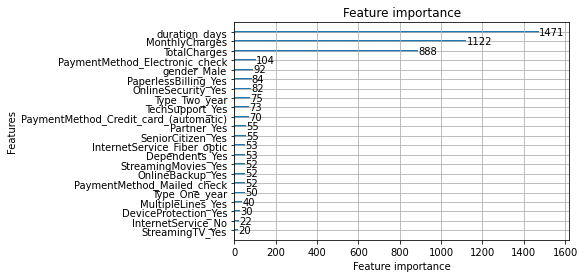

In [54]:
lightgbm.plot_importance(grid.best_estimator_)

Отметим, что наибольшую значимость для нашей  модели имеют количественные признаки (оплата и продолжительность услуги).

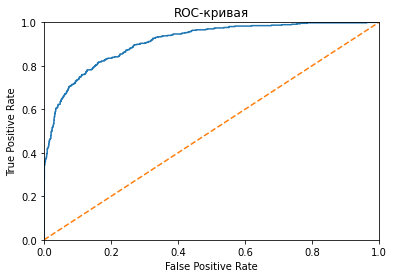

In [55]:
def make_roc_curve(target, probabilities_one):
    fpr, tpr, thresholds = roc_curve(target, probabilities_one)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    
make_roc_curve(y_test, pred)

In [56]:
simple_models['LGBMClassifier'] = [accuracy, roc_auc]
simple_models

,Decision Tree,Random Forest,Logistic Regression,LGBMClassifier
accuracy,0.762230,0.808874,0.810011,0.838453
roc_auc,0.694429,0.840645,0.840516,0.911108


Модель LGBMClassifier показала результат roc_auc: 0.91, что полностью удовлетворяет поставленным задачам.

## Вывод

Провдена предобработка данных, с заполнением пропущенных значений и удалением неполных наблюдений. В результате исследовательского анализа выявлено, что:
- с увеличением помесячных платежей кол-во ушедших клиентов увеличивается
- в первые месяцы кол-во ушедших клиентов велико, однако со временем их кол-во уменьшается.
- большая доля ушедших среди пользователелей пользующиеся безналичнам расчетом 

Вышеперечисленные факторы имели решающее значение, что подтверждено показателями влияния признаков на лучшую из расмотренных моделей.

Обучив 4 различных моделей, лучшие показатели метрики показала модель LGBMClassifier с показателями:
- roc_auc: 0.91
- accuracy: 0.83

Рекомдуем использовать LGBMClassifier для решения задачи предсказания оттока клиентов компании.

# Отчет

Проект выполнялся в соответствии с намеченным планом, все пункты которого удалось выполнить. 

Основная трудность состояла в достижении приемлемых в соответствии с целью показателей метрики roc - auc (от 0.85), чего не удавалось достичь ни с одной из расмотренных моделей и долгим подбором оптимальных параметров. Решена проблема была путем добавления одного из ключевого признака для модели - продожительность пользования услуг клиентом.

Ключевыми шагами можно выделить анализ целевого признака и влияние на него других. Этот этап позволил осознать важность и завести признак продолжительности пользования услугами компании. Сначало это было посчитано в месяцах, что не оказало значительного эффекта, однако пересчет его в дни позволило добиться поставленной цели.

Лучшие показатели метрики показала модель с применением градиентного бустинга LGBMClassifier при параметрах:
'max_depth': 4, 'n_estimators': 400, objective='binary', class_weight='balanced', num_leaves=100.

Показатели метрики:
- roc_auc: 0.91
- accuracy: 0.83
